In [1]:
pip install qulacs

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [540]:
from pennylane import qaoa
from pennylane import numpy as np
import pennylane as qml

import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-notebook')
import json


In [550]:

def generate_portfolio_data(N):
    """
    Generates data for the portfolio optimization problem.
    
    Args:
        N (int): Number of stocks in the portfolio.

    Returns:
        dict: A dictionary containing the generated data.
    """
    # Randomly generate expected returns for each stock
    r = np.random.uniform(0, 1, N)
    
    # Generate the covariance matrix
    cov_matrix = np.random.uniform(-0.01, 0.01, (N, N))
    
    # Ensure it's symmetric
    cov_matrix = (cov_matrix + cov_matrix.T) / 2
    
    # Set the diagonal to represent variances
    np.fill_diagonal(cov_matrix, np.random.uniform(0.01, 0.5, N))
    
    # Calculate A (using a default weighting factor w=0.5 for simplicity)
    w = 0.5
    A = (1-w) * 2 * cov_matrix - w * np.diag(r)
    
    return {
        'r': r,
        'cov_matrix': cov_matrix,
    }




class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):  # Convert numpy arrays
            return obj.tolist()
        if 'tensor' in str(type(obj)):  # Convert tensors (basic assumption, might need adjustment)
            return obj.numpy().tolist()  # Assuming you can convert tensor to numpy
        return super().default(obj)

#json_obj = {'r':r,
# 'cov_matrix':cov_matrix}


#with open('QCCC/example_input_n=n.json', 'w') as json_file:
#    json.dump(json_obj, json_file, cls=CustomEncoder)

    

In [551]:
N = 4
portfolio_data = generate_portfolio_data(N)
r = portfolio_data['r']
cov_matrix = portfolio_data['cov_matrix']
r,cov_matrix

(tensor([0.34197898, 0.64721647, 0.27720048, 0.51582432], requires_grad=True),
 tensor([[ 0.06347498,  0.00380937, -0.00467495,  0.00508954],
         [ 0.00380937,  0.44966626,  0.00726831, -0.00540308],
         [-0.00467495,  0.00726831,  0.03085374,  0.00482647],
         [ 0.00508954, -0.00540308,  0.00482647,  0.20834973]], requires_grad=True))

## Classical Portfolio Optimization (Markowitz Mean-Variance Optimization)

### Objective:

Given a set of assets, we want to find the optimal allocation of investments in these assets to maximize returns while minimizing risk.

### Mathematical Formulation:

#### Let:

- r be a column vector of expected returns for each asset.

- w be a column vector of weights for each asset, representing the fraction of total investment in that asset. 

    We have the constraint: ∑<sub>i</sub> w<sub>i</sub> = 1
- Σ be the covariance matrix of asset returns.


#### Portfolio Expected Return:

 R<sub>p</sub> = w<sup>T</sup>r

#### Portfolio Variance (Risk):
σ<sup>2</sup><sub>p</sub> =  w<sup>T</sup> Σ w


### Optimization Problem:

maximize R<sub>p</sub> − λσ<sup>2</sup><sub>p</sub>

#### Subject to:

∑<sub>i</sub> w<sub>i</sub> = 1

#### Where:

λ is a parameter that determines the trade-off between risk and return.



In [555]:

# 1. Define Global Parameters
N = 10  # Number of stocks
w = 0.5  # weighting / trade-off factor
depth = 4  # Depth of the QAOA circuit
wires = range(N)


#portfolio_data = generate_portfolio_data(N)

with open('QCCC/example_input_n=10.json', 'r') as json_file:
    data = json.load(json_file)

# Convert lists to numpy arrays
r = np.array(data['r'])
cov_matrix = np.array(data['cov_matrix'])

print("Expected Returns: \n\n", np.round(r,3),"\n")
print("\nCovariance Matrix: \n\n", np.round(cov_matrix, 3), "\n")

Expected Returns: 

 [0.916 0.551 0.019 0.106 0.16  0.041 0.618 0.269 0.271 0.734] 


Covariance Matrix: 

 [[ 0.064  0.001  0.004 -0.008 -0.     0.007 -0.003  0.001 -0.001  0.002]
 [ 0.001  0.221  0.     0.003 -0.008 -0.001 -0.001 -0.004  0.     0.003]
 [ 0.004  0.     0.1   -0.006  0.004  0.004  0.003 -0.009  0.005 -0.002]
 [-0.008  0.003 -0.006  0.301  0.001 -0.     0.001 -0.002 -0.     0.003]
 [-0.    -0.008  0.004  0.001  0.319 -0.     0.002  0.004  0.007 -0.004]
 [ 0.007 -0.001  0.004 -0.    -0.     0.122  0.008 -0.001 -0.004  0.003]
 [-0.003 -0.001  0.003  0.001  0.002  0.008  0.283  0.004  0.003 -0.002]
 [ 0.001 -0.004 -0.009 -0.002  0.004 -0.001  0.004  0.257 -0.001 -0.001]
 [-0.001  0.     0.005 -0.     0.007 -0.004  0.003 -0.001  0.029 -0.003]
 [ 0.002  0.003 -0.002  0.003 -0.004  0.003 -0.002 -0.001 -0.003  0.03 ]] 



# QUBO Formulation
For quantum computing applications, the continuous variables in the Markowitz problem (the weights w) can be hard to handle. 
Instead, a binary representation is preferred, leading to a QUBO formulation.

Assume we restrict our investment decisions to whether or not we should invest in a particular asset (binary decision: yes or no), without considering the fractional amount.



#### Let:

z be a binary vector, where z<sub>i</sub> = 1 if we invest in asset i and z<sub>i</sub> = 0 otherwise.

The QUBO problem can then be described as:

E(z)=−a<sup>T</sup>z + z<sup>T</sup>Bz

or 

E(z)= z<sup>T</sup>Bz −a<sup>T</sup>z 


#### Where:
- a is the expected returns of the assets.
- B is covariance matrix of the assets.

The objective is to find the binary vector z that minimizes E(z).

In [558]:
# Generate QUBO Matrix

A = (1-w)*2*cov_matrix - w*np.diag(r)
print(np.round(A, 3)) 

[[-0.394  0.001  0.004 -0.008 -0.     0.007 -0.003  0.001 -0.001  0.002]
 [ 0.001 -0.055  0.     0.003 -0.008 -0.001 -0.001 -0.004  0.     0.003]
 [ 0.004  0.     0.091 -0.006  0.004  0.004  0.003 -0.009  0.005 -0.002]
 [-0.008  0.003 -0.006  0.248  0.001 -0.     0.001 -0.002 -0.     0.003]
 [-0.    -0.008  0.004  0.001  0.239 -0.     0.002  0.004  0.007 -0.004]
 [ 0.007 -0.001  0.004 -0.    -0.     0.101  0.008 -0.001 -0.004  0.003]
 [-0.003 -0.001  0.003  0.001  0.002  0.008 -0.026  0.004  0.003 -0.002]
 [ 0.001 -0.004 -0.009 -0.002  0.004 -0.001  0.004  0.123 -0.001 -0.001]
 [-0.001  0.     0.005 -0.     0.007 -0.004  0.003 -0.001 -0.106 -0.003]
 [ 0.002  0.003 -0.002  0.003 -0.004  0.003 -0.002 -0.001 -0.003 -0.337]]


## Quantum Approximate Optimization Algorithm (QAOA)
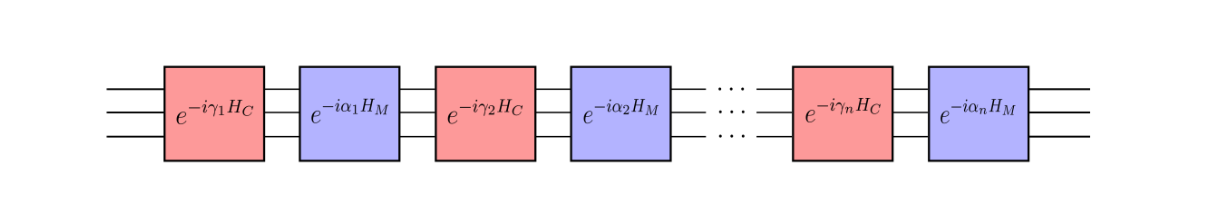

In [559]:

# 2. Hamiltonian Construction

def cost_hamiltonian():
    """
    Constructs the cost Hamiltonian based on the QUBO matrix A.
    
    The cost Hamiltonian represents the problem we aim to solve. The matrix A encodes the 
    coefficients of the QUBO problem. This function constructs a Hamiltonian where each term 
    corresponds to a non-zero coefficient in A. The resulting Hamiltonian is suitable for quantum 
    optimization algorithms like QAOA.
    
    Returns:
        qml.Hamiltonian: The constructed cost Hamiltonian.
        
    Global Variables:
        A (np.ndarray): The QUBO matrix.
    """
    
    n = len(A)  # Get the size of the QUBO matrix
    H = qml.Hamiltonian([], [])  # Initialize an empty Hamiltonian

    # Loop through each entry of the QUBO matrix
    for i in range(n):
        for j in range(n):
            if A[i, j]:  # If the matrix entry is non-zero
                # Initialize a list of identity operations for each qubit
                ops = [qml.Identity(w) for w in range(n)]
                # Replace the j-th operator with a PauliZ
                ops[j] = qml.PauliZ(j)
                # Create a tensor product of the operators
                tensor_op = qml.operation.Tensor(*ops)
                # Add the term to the Hamiltonian with coefficient A[i,j]
                H += qml.Hamiltonian([A[i, j]], [tensor_op])

    return H  # Return the constructed cost Hamiltonian

def mixer_hamiltonian():
    """
    Constructs the mixer Hamiltonian.
    
    The mixer Hamiltonian helps in diversifying the search over all possible states. 
    It consists of PauliX operations on each qubit. During the QAOA algorithm, the mixer 
    Hamiltonian drives transitions between different states in the search space.
    
    Returns:
        qml.Hamiltonian: The constructed mixer Hamiltonian.
        
    Global Variables:
        N (int): The number of qubits.
    """
    
    # Coefficients for each PauliX term are set to 1
    coeffs = [1 for _ in range(N)]
    # PauliX operations for each qubit
    obs = [qml.PauliX(i) for i in range(N)]
    return qml.Hamiltonian(coeffs, obs)  # Return the mixer Hamiltonian

# Construct the cost and mixer Hamiltonians
cost_h = cost_hamiltonian()
mixer_h = mixer_hamiltonian()


In [560]:
cost_h

  (-0.3910638795391579) [Z0]
+ (-0.3374359494126917) [Z9]
+ (-0.10049904704205558) [Z8]
+ (-0.06197819864616051) [Z1]
+ (-0.011441310563624726) [Z6]
+ (0.09356937184265458) [Z2]
+ (0.11590932767809804) [Z5]
+ (0.11631859025503717) [Z7]
+ (0.24034915883920688) [Z3]
+ (0.2437291664059884) [Z4]


In [561]:
mixer_h

  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]
+ (1) [X6]
+ (1) [X7]
+ (1) [X8]
+ (1) [X9]


qaoa_layer: This function represents a single layer of the QAOA circuit. Each QAOA layer consists of two parts: the cost layer (driven by the cost Hamiltonian) and the mixer layer (driven by the mixer Hamiltonian). The parameters gamma and alpha control the strength of the cost and mixer terms, respectively.

cost_circuit: This function constructs the full QAOA circuit for a given set of parameters. It starts by preparing a superposition of all possible computational basis states using Hadamard gates. It then applies multiple QAOA layers (as defined by qaoa_layer), with the number of layers being set by depth. The output of the circuit is the expectation value of the cost Hamiltonian, which indicates the "cost" or "quality" of the current state produced by the QAOA circuit.

cost_function: This is a QNode, which serves as an interface between classical and quantum computations. It allows you to compute the expectation value of the cost Hamiltonian for a given set of QAOA parameters. This QNode will be evaluated many times during the classical optimization process to find the best set of parameters for the QAOA circuit. The goal of the classical optimization is to adjust the QAOA parameters to produce a quantum state that corresponds to the optimal or near-optimal solution to the problem.

In [566]:
# 3. QAOA Circuit
wires = range(N)

def qaoa_layer(gamma, alpha):
    """
    Implements one layer of the QAOA circuit.
    
    Each layer consists of two sub-layers: 
    1. A cost layer that applies e^(-i*gamma*cost_hamiltonian) to the state, which "marks" the 
       good solutions by introducing phase differences.
    2. A mixer layer that applies e^(-i*alpha*mixer_hamiltonian) to diversify the search 
       over the state space.
    
    Parameters:
        gamma (float): Parameter controlling the cost layer.
        alpha (float): Parameter controlling the mixer layer.
    """
    
    # Apply the cost layer
    qml.qaoa.cost_layer(gamma, cost_h)
    # Apply the mixer layer
    qml.qaoa.mixer_layer(alpha, mixer_h)

def cost_circuit(params, **kwargs):
    """
    Constructs the full QAOA circuit.
    
    The circuit initializes all qubits in a superposition state using Hadamard gates. 
    It then applies multiple QAOA layers, where the number of layers is determined by 
    the depth. The output is the expectation value of the cost Hamiltonian, which gives 
    the cost of the current state produced by the QAOA circuit.
    
    Parameters:
        params (array[float]): The parameters of the QAOA circuit. It's expected to be 
                               of shape (2, depth), where params[0] are the gammas and 
                               params[1] are the alphas.
    
    Returns:
        float: Expectation value of the cost Hamiltonian for the state produced by the circuit.
    """
    
    # Initialize all qubits in a superposition state
    for w in wires:
        qml.Hadamard(wires=w)
    # Apply QAOA layers
    qml.layer(qaoa_layer, depth, params[0], params[1])
    
    # Return the expectation value of the cost Hamiltonian
    return qml.expval(cost_h)




# Define a quantum device. Here, we're using the "qulacs.simulator" backend.
dev = qml.device("qulacs.simulator", wires=N)

@qml.qnode(dev)
def cost_function(params):
    """
    QNode wrapper for the QAOA cost circuit.
    
    This function serves as a bridge between the classical and quantum parts of the algorithm. 
    It takes in classical parameters and returns the quantum expectation value by running the 
    cost_circuit on the defined quantum device. This expectation value will be used during 
    classical optimization to adjust the QAOA parameters for better solutions.
    
    Parameters:
        params (array[float]): The parameters of the QAOA circuit. Shape is (2, depth).
    
    Returns:
        float: Expectation value of the cost Hamiltonian.
    """
    return cost_circuit(params)


In [567]:

# 4. Optimization Loop
initial_gammas = np.random.uniform(0, 2 * np.pi, depth)
initial_betas = np.random.uniform(0, np.pi, depth)
params = np.array([initial_gammas, initial_betas], requires_grad=True)

optimizer = qml.GradientDescentOptimizer()
steps = 25
for i in range(steps):
    if i%5==0:
        print(f"{i}/{steps}")
    params = optimizer.step(cost_function, params)
    
print(f"{i+1}/{steps}")
print(f'Optimal Parameters:\n{params}')


0/25
5/25
10/25
15/25
20/25
25/25
Optimal Parameters:
[[4.68879737 1.09913692 1.83285423 4.20327061]
 [1.22088562 2.5769457  2.87638505 1.58087041]]


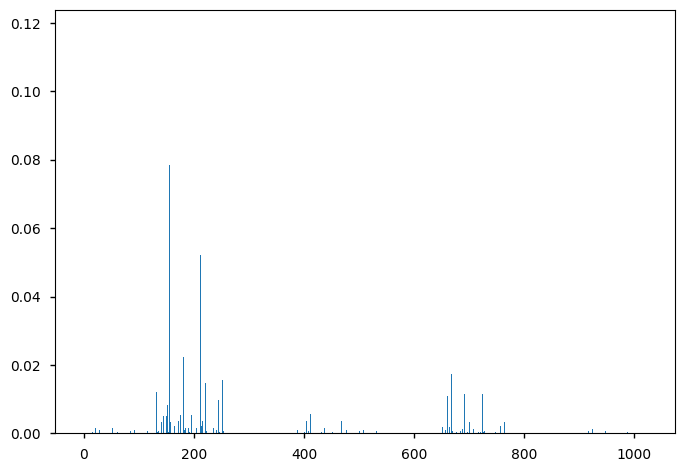

In [527]:

# 5. Probability Distribution Visualization
dev = qml.device("default.qubit", wires=N)
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    """QNode for the probability distribution."""
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, gamma, alpha)
    return qml.probs(wires=wires)

gamma_vals, alpha_vals = params
probs = probability_circuit(gamma_vals, alpha_vals)
plt.bar(range(2 ** N), probs)
plt.show()

In [528]:

# 6. Sampling
dev = qml.device("default.qubit", wires=N, shots=10000)
def sampling_circuit(params, **kwargs):
    """QNode for sampling from the circuit."""
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])
    return [qml.sample(qml.PauliZ(w)) for w in wires]

@qml.qnode(dev)
def sample_function(params):
    """Sample from the optimized QAOA circuit."""
    return sampling_circuit(params)

optimal_params = params.copy()

samples_array = np.array(sample_function(optimal_params))
samples_transposed = samples_array.T
#  Convert -1 to 0 to get the bitstrings
bitstrings = np.where(samples_transposed == -1, 0, samples_transposed)

# Convert to string for easy counting
string_bits = [''.join(map(str, bitstring)) for bitstring in bitstrings]

# Count occurrences
bitstring_counts = Counter(string_bits)

# Get the most common bitstring
optimal_bitstring = bitstring_counts.most_common(1)[0][0]
optimal_bitstring


'1101101011'

In [529]:
print(" Expected Returns: \n\n", np.round(r,3),"\n")


 Expected Returns: 

 [0.916 0.551 0.019 0.106 0.16  0.041 0.618 0.269 0.271 0.734] 



In [530]:
def calculate_sharpe_ratio(optimal_bitstring, r, cov_matrix, risk_free_rate=0.01):
    """
    Calculates the Sharpe ratio for a given portfolio defined by the optimal_bitstring.
    
    Args:
        optimal_bitstring (str): The string representation of the portfolio (1 for included stocks, 0 for excluded).
        r (list): Expected returns for individual stocks.
        cov_matrix (np.ndarray): Covariance matrix for the stocks.
        risk_free_rate (float, optional): The risk-free rate. Defaults to 0.01.

    Returns:
        float: The calculated Sharpe ratio.
    """
    # Convert bitstring to a list of integers
    allocation = [int(bit) for bit in optimal_bitstring]
    
    # Expected portfolio return
    expected_return = np.dot(allocation, r)
    
    # Portfolio variance and standard deviation
    portfolio_variance = np.dot(allocation, np.dot(cov_matrix, allocation))
    portfolio_std_dev = np.sqrt(portfolio_variance)
    
    # Sharpe ratio
    sharpe_ratio = (expected_return - risk_free_rate) / portfolio_std_dev
    
    return sharpe_ratio, expected_return/sum(allocation)

# Example Usage
def calculate_all_sharpe_ratios(bitstrings, r, cov_matrix):
    return [calculate_sharpe_ratio(bitstring, r, cov_matrix)[0] for bitstring in bitstrings]

# Calculate Sharpe ratios for all bitstrings
def calculate_all_ers(bitstrings, r, cov_matrix):
    return [calculate_sharpe_ratio(bitstring, r, cov_matrix)[1] for bitstring in bitstrings]


In [531]:
sharpe_ratio, expected_return = calculate_sharpe_ratio(optimal_bitstring, portfolio_data['r'], portfolio_data['cov_matrix'])
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Expected Return: {expected_return:.4f}")

Sharpe Ratio: 3.0080
Expected Return: 0.4794


In [532]:
all_sharpe_ratios = calculate_all_sharpe_ratios(bitstrings, portfolio_data['r'], portfolio_data['cov_matrix'])
all_sharpe_ers = calculate_all_ers(bitstrings, portfolio_data['r'], portfolio_data['cov_matrix'])


In [533]:
all_sharpe_ratios.mean(),all_sharpe_ers.mean()

AttributeError: 'list' object has no attribute 'mean'

In [ ]:
all_sharpe_ratios[137],all_sharpe_ers[137]

In [508]:
# Sort the Sharpe ratios while retaining their original index
sorted_indices = sorted(enumerate(all_sharpe_ratios), key=lambda x: x[1], reverse=True)

# Extract the top 10
top_10 = sorted_indices[:10]

# Display top 10 Sharpe ratios and their positions
for idx, value in top_10:
    print(f"Position: {idx}, Sharpe Ratio: {value:.4f}")


Position: 293, Sharpe Ratio: 3.6038
Position: 712, Sharpe Ratio: 3.6038
Position: 6062, Sharpe Ratio: 3.6038
Position: 7478, Sharpe Ratio: 3.6038
Position: 729, Sharpe Ratio: 3.5901
Position: 2118, Sharpe Ratio: 3.5901
Position: 5082, Sharpe Ratio: 3.5901
Position: 4214, Sharpe Ratio: 3.5632
Position: 5271, Sharpe Ratio: 3.5632
Position: 7028, Sharpe Ratio: 3.5632


In [509]:
# Sort the Sharpe ratios while retaining their original index
sorted_indices = sorted(enumerate(all_sharpe_ers), key=lambda x: x[1], reverse=True)

# Extract the top 10
top_10 = sorted_indices[:10]

# Display top 10 Sharpe ratios and their positions
for idx, value in top_10:
    print(f"Position: {idx}, Expected Return: {value:.4f}")


Position: 2591, Expected Return: 0.9069
Position: 946, Expected Return: 0.8489
Position: 3674, Expected Return: 0.8489
Position: 6136, Expected Return: 0.8489
Position: 9823, Expected Return: 0.8489
Position: 2343, Expected Return: 0.8197
Position: 8003, Expected Return: 0.8197
Position: 9360, Expected Return: 0.8197
Position: 193, Expected Return: 0.8027
Position: 359, Expected Return: 0.8027


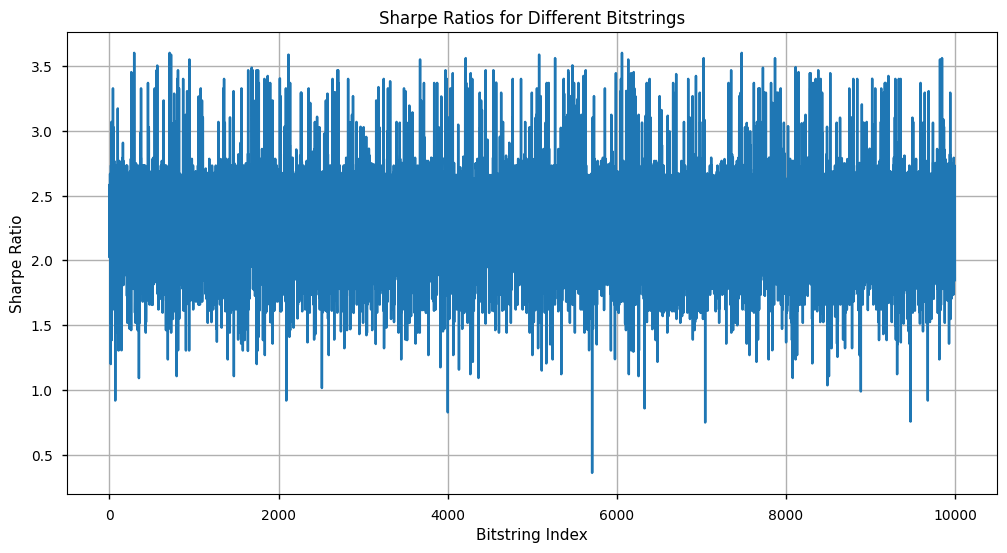

In [510]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(all_sharpe_ratios)
plt.xlabel('Bitstring Index')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios for Different Bitstrings')
plt.grid(True)
plt.show()